# Project Overview

## Datasets

This project utilizes the MovieLens dataset, a widely used dataset in the field of recommender systems, containing movie ratings and metadata.  The data was obtained at https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data.  There are two data files. The first contains the unique movie Id, movie title and a list of genres the movie falls into.  The second consists of user ratings with the user ID, movie ID, rating and timestap of when the review was made.


## 1. Imports and Constants

- Purpose: This section imports all the necessary libraries and sets constants that are used throughout the script.
- Summary:
    - Libraries like pandas, numpy, matplotlib, and seaborn are imported for data manipulation, numerical operations, and visualization.
    - The surprise library is imported for building collaborative filtering models.
    sklearn is used for metrics evaluation and feature scaling.
    - Constants such as file paths (MOVIES_FILE, RATINGS_FILE), number of recommendations (N_RECOMMENDATIONS), weights for different components of the recommendation system, and random seed (RANDOM_SEED) are defined to control various aspects of the recommendation process.


In [5]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import warnings  # Suppress warnings
import itertools  # Handling iterators
import re  # Regular expressions for string matching
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
import time  # Time utilities
from surprise import Dataset, Reader, SVD  # Surprise library for collaborative filtering
from surprise.model_selection import train_test_split, GridSearchCV  # Model selection utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score  # Metrics for evaluation
from sklearn.metrics.pairwise import cosine_similarity  # Cosine similarity for content-based filtering
from sklearn.preprocessing import StandardScaler  # Standard scaling of features
from joblib import Parallel, delayed  # Parallel processing

# Suppress warnings from deprecated or future features
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Constants for file paths and parameters used throughout the script
MOVIES_FILE = '../data/movies.csv'  # Path to movies data file
RATINGS_FILE = '../data/ratings.csv'  # Path to ratings data file
N_RECOMMENDATIONS = 5  # Number of recommendations to generate per user
YEAR_DIVISOR = 0.01  # Factor to give more importance to recent movies
RATING_THRESHOLD = 4.0  # Threshold to consider a recommendation positive
RANDOM_SEED = 42  # Seed for random number generators for reproducibility
USER_SAMPLE_SIZE = 500  # Number of users to sample for recommendations

# Weights for different scoring components in the recommendation system
CF_WEIGHT = 0.7  # Weight for collaborative filtering score
CBF_WEIGHT = 0.3  # Weight for content-based filtering score
POPULARITY_PENALTY_WEIGHT = 0.8  # Weight for penalizing popular items
TIME_DECAY_FACTOR = 0.1  # Factor for time decay of ratings
RECENCY_WEIGHT = 1.5  # Weight for recency in hybrid score

# Set the random seed for NumPy to ensure reproducibility of results
np.random.seed(RANDOM_SEED)


## 2. Loading and Preprocessing Data
- Purpose: This function loads and preprocesses movie and ratings data from CSV files.
- Summary:
    - The function reads movie and rating data into pandas DataFrames.
    - It converts timestamps in the ratings data to datetime objects and merges the ratings with movie data based on the movieId.
    - It extracts the release year from movie titles if it's not already present and one-hot encodes the genres into separate columns.
    - The function handles any potential errors during data loading and returns the merged DataFrame along with the original movies and ratings DataFrames.

In [7]:
def load_data(movies_file, ratings_file):
    """
    Load and preprocess movies and ratings data.

    This function loads movie and rating data from CSV files, converts timestamps to datetime objects,
    merges the data on movie IDs, extracts release years from titles, and one-hot encodes genres.

    Parameters:
        movies_file (str): Path to the movies data file.
        ratings_file (str): Path to the ratings data file.

    Returns:
        tuple: Three DataFrames (merged_df, movies_df, ratings_df)
               - merged_df: DataFrame containing merged movies and ratings data with additional features.
               - movies_df: DataFrame containing the original movies data.
               - ratings_df: DataFrame containing the original ratings data.
    """
    try:
        movies_df = pd.read_csv(movies_file)  # Load movies data
        ratings_df = pd.read_csv(ratings_file)  # Load ratings data
        ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')  # Convert timestamps

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')  # Merge ratings and movies data on movieId

        # Extract release years from the movie titles if not already done
        if 'release_year' not in merged_df.columns:
            merged_df['release_year'] = merged_df['title'].str.extract(r'\((\d{4})\)')[0].astype(float)

        # One-hot encode genres into separate columns
        genre_list = list(set(itertools.chain.from_iterable(merged_df['genres'].str.split('|'))))
        for genre in genre_list:
            genre_pattern = re.escape(genre)  # Escape any special characters in genre names
            merged_df[genre] = merged_df['genres'].str.contains(r'\b' + genre_pattern + r'\b').astype(int)

        return merged_df, movies_df, ratings_df  # Return the merged and original dataframes
    except FileNotFoundError as fnf_error:
        raise FileNotFoundError(f"File not found: {fnf_error}")  # Handle file not found errors
    except Exception as e:
        raise RuntimeError(f"Error loading data: {e}")  # Handle any other errors


## 3. Exploratory Data Analysis (EDA)
- Purpose: This function performs Exploratory Data Analysis (EDA) on the merged movie and ratings data.
- Summary:
    - The function prints out basic information about the data, such as the first few rows, data shape, info, and descriptive statistics.
    - It visualizes the distribution of ratings, the top 10 movies by number of ratings, the top 10 users by number of ratings, genre distribution, and the distribution of movie release years using various plots.
    - It also displays a correlation matrix to understand the relationships between different numeric features in the data.

In [9]:
def perform_eda(merged_df):
    """
    Perform Exploratory Data Analysis (EDA) on the merged movies and ratings data.

    This function prints out information and displays plots to help understand the structure and distribution
    of the merged movies and ratings data. Plots include distribution of ratings, number of ratings per movie,
    number of ratings per user, genre distribution, and distribution of movie release years.

    Parameters:
        merged_df (pd.DataFrame): DataFrame containing merged movies and ratings data.
    """
    # Display basic information about the merged DataFrame
    print("Merged DataFrame:")
    print(merged_df.head())  # Show the first few rows of the merged DataFrame

    print("\nShape of Merged DataFrame:", merged_df.shape)  # Display the shape of the DataFrame

    print("\nMerged DataFrame Info:")
    print(merged_df.info())  # Display info about the DataFrame, including data types and non-null counts

    print("\nMerged DataFrame Description:")
    print(merged_df.describe())  # Display descriptive statistics for numeric columns

    print("\nMissing Values in Merged DataFrame:")
    print(merged_df.isnull().sum())  # Display the count of missing values in each column

    # Plot the distribution of ratings
    plt.figure(figsize=(10, 5))
    bins = np.arange(0.5, 5.5, 0.5)  # Set bins for rating distribution
    sns.histplot(merged_df['rating'], bins=bins, kde=False)  # Plot histogram of ratings
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.xticks(bins)  # Set x-ticks to match the bins
    plt.show()

    # Plot the top 10 movies by number of ratings
    top_movies = merged_df['movieId'].value_counts().nlargest(10)  # Get top 10 movies by rating count
    top_movies_titles = merged_df[merged_df['movieId'].isin(top_movies.index)].drop_duplicates('movieId').set_index('movieId').loc[top_movies.index]['title']
    plt.figure(figsize=(10, 5))
    sns.barplot(y=top_movies_titles, x=top_movies.values, palette='viridis')  # Plot top movies
    plt.title('Top 10 Movies by Number of Ratings')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Movie Title')
    plt.show()

    # Plot the top 10 users by number of ratings
    top_users = merged_df['userId'].value_counts().nlargest(10)  # Get top 10 users by rating count
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_users.index.astype(int), y=top_users.values, palette='viridis')  # Plot top users
    plt.title('Top 10 Users by Number of Ratings')
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    plt.show()

    # Plot the genre distribution
    merged_df['genres'] = merged_df['genres'].str.split('|')  # Split genres into lists
    all_genres = merged_df['genres'].explode().value_counts()  # Count occurrences of each genre
    plt.figure(figsize=(12, 6))
    sns.barplot(x=all_genres.values, y=all_genres.index, palette='viridis')  # Plot genre distribution
    plt.title('Genre Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Genre')
    plt.show()

    # Plot the distribution of movie release years
    merged_df['release_year'] = merged_df['release_year'].astype(float)  # Ensure release years are float
    plt.figure(figsize=(10, 5))
    sns.histplot(merged_df['release_year'].dropna(), bins=int(merged_df['release_year'].max() - merged_df['release_year'].min() + 1), kde=False)
    plt.title('Distribution of Movie Release Years')
    plt.xlabel('Release Year')
    plt.ylabel('Frequency')
    plt.show()



## 4. Applying Time Decay
- Purpose: This function applies a time decay to the ratings, giving more importance to recent ratings and newer movies.
- Summary:
    - The function calculates the time difference in days between the current time and when each rating was given.
    - It then applies a decay factor based on this time difference and the release year of the movie, normalizing the ratings to a 0.5 - 5.0 scale.
    - The adjusted ratings are returned as part of the original DataFrame.

In [11]:
def apply_time_decay(ratings_df, decay_factor, year_divisor):
    """
    Apply time decay to ratings.

    This function adjusts the ratings based on the time since the rating was given and the release year of the movie.
    More recent ratings and newer movies are given higher importance.

    Parameters:
        ratings_df (pd.DataFrame): DataFrame containing ratings data.
        decay_factor (float): Decay factor for time decay.
        year_divisor (float): Divisor for year difference to adjust importance of release year.

    Returns:
        pd.DataFrame: DataFrame with adjusted ratings.
    """
    current_time = pd.to_datetime('now')  # Get the current time
    time_diff_days = (current_time - ratings_df['timestamp']).dt.total_seconds() / (3600 * 24)  # Calculate time difference in days
    time_weights = decay_factor ** (time_diff_days / 365)  # Calculate time decay weights

    year_diff = (current_time.year - ratings_df['release_year']) / year_divisor  # Calculate year difference for movies
    adjusted_ratings = ratings_df['rating'] * time_weights / (1 + year_diff)  # Adjust ratings based on time decay and year difference

    # Normalize adjusted ratings to a 0.5 - 5.0 scale
    min_rating, max_rating = adjusted_ratings.min(), adjusted_ratings.max()
    if (min_rating != max_rating) and (min_rating != float('inf')) and (max_rating != float('inf')):
        adjusted_ratings = 5.0 * (adjusted_ratings - min_rating) / (max_rating - min_rating)

    ratings_df['adjusted_rating'] = adjusted_ratings.clip(0.5, 5.0).round(1)  # Clip and round adjusted ratings

    return ratings_df  # Return the DataFrame with adjusted ratings


## 5. Standardizing Features
- Purpose: This function standardizes selected features in the DataFrame.
- Summary:
    - It uses StandardScaler to scale specified features to have zero mean and unit variance, which is often necessary for machine learning models to perform effectively.
    - The function returns the DataFrame with standardized features.

In [13]:
def standardize_features(df, feature_columns):
    """
    Standardize selected features in the dataframe.

    This function scales the specified features to have zero mean and unit variance.

    Parameters:
        df (pd.DataFrame): DataFrame containing data.
        feature_columns (list): List of feature columns to standardize.

    Returns:
        pd.DataFrame: DataFrame with standardized features.
    """
    scaler = StandardScaler()  # Initialize the standard scaler
    df[feature_columns] = scaler.fit_transform(df[feature_columns])  # Apply scaling to the feature columns
    return df  # Return the DataFrame with standardized features


## 6. Extracting Item Features
- Purpose: This function extracts unique item features from the DataFrame and handles any columns with all zero values.
- Summary:
    - The function drops duplicate entries and sets movieId as the index to get unique item features.
    - It identifies and removes columns where all values are zero, as these features provide no useful information.
    - The function returns the item features DataFrame and a list of non-zero columns.

In [15]:
def get_item_features(df, feature_columns):
    """
    Extract item features from the dataframe.

    This function retrieves unique item features and handles any columns with all zero values.

    Parameters:
        df (pd.DataFrame): DataFrame containing data.
        feature_columns (list): List of feature columns.

    Returns:
        tuple: DataFrame of item features with movieId as index, and list of non-zero columns.
    """
    item_features = df[['movieId'] + feature_columns].drop_duplicates().set_index('movieId')  # Get unique item features
    item_features = item_features.loc[~item_features.index.duplicated(keep='first')].fillna(0)  # Remove duplicates and fill NaN values

    zeroed_columns = [col for col in item_features.columns if item_features[col].sum() == 0]  # Identify columns with all zeros
    if zeroed_columns:
        item_features = item_features.drop(columns=zeroed_columns)  # Remove zeroed columns

    non_zero_columns = item_features.columns.tolist()  # Get list of non-zero columns
    return item_features, non_zero_columns  # Return item features and non-zero columns


### 6.A. Add Functions to Calculate and Plot Item Similarity


In [17]:
def calculate_item_similarity(item_features):
    """
    Calculate the item similarity matrix based on cosine similarity.
    
    Parameters:
        item_features (pd.DataFrame): DataFrame containing item features.
        
    Returns:
        pd.DataFrame: DataFrame containing item similarity values.
    """
    # Calculate cosine similarity between items
    item_similarity = cosine_similarity(item_features)
    
    # Convert to DataFrame for easier manipulation
    item_similarity_df = pd.DataFrame(item_similarity, index=item_features.index, columns=item_features.index)
    
    return item_similarity_df

def plot_item_similarity_matrix_with_clustering(item_similarity_df):
    """
    Calculate, cluster, and plot the item similarity matrix.
    
    This function applies hierarchical clustering to the item similarity matrix and plots it.
    
    Parameters:
        item_similarity_df (pd.DataFrame): DataFrame containing item similarity values.
    """
    # Hierarchical clustering
    linkage_matrix = linkage(item_similarity_df, method='ward')
    
    # Reorder the item_similarity matrix according to the clustering
    dendro = dendrogram(linkage_matrix, no_plot=True)
    ordered_item_ids = item_similarity_df.index[dendro['leaves']]
    ordered_similarity_df = item_similarity_df.loc[ordered_item_ids, ordered_item_ids]
    
    # Plot the clustered similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(ordered_similarity_df, annot=False, cmap='coolwarm', fmt='.2f')
    plt.title('Clustered Item Similarity Matrix')
    plt.show()


## 7. Deriving User Preferences
- Purpose: This function calculates user preferences based on the features of the items they have rated.
- Summary:
    - It computes the mean feature values for each user, representing their preferences for different genres or other item characteristics.
    - The resulting DataFrame contains the derived user preferences, with NaN values filled in as zeros.

In [19]:
def derive_user_preferences(df, feature_columns):
    """
    Calculate user preferences based on features.

    This function computes the mean feature values for each user, representing their preferences.

    Parameters:
        df (pd.DataFrame): DataFrame containing data.
        feature_columns (list): List of feature columns.

    Returns:
        pd.DataFrame: DataFrame of user preferences.
    """
    user_genre_means = df.groupby('userId')[feature_columns].mean().add_prefix('user_mean_')  # Calculate mean feature values for each user
    return user_genre_means.fillna(0)



In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_user_similarity_matrix_with_clustering(user_preferences):
    """
    Calculate, cluster, and plot the user similarity matrix.
    
    This function calculates the cosine similarity between user preference vectors,
    applies hierarchical clustering, and plots the resulting similarity matrix.
    
    Parameters:
        user_preferences (pd.DataFrame): DataFrame containing user preference vectors.
    """
    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_preferences)
    
    # Hierarchical clustering
    linkage_matrix = linkage(user_similarity, method='ward')
    
    # Reorder the user_similarity matrix according to the clustering
    dendro = dendrogram(linkage_matrix, no_plot=True)
    ordered_user_ids = user_preferences.index[dendro['leaves']]
    user_similarity_df = pd.DataFrame(user_similarity, index=user_preferences.index, columns=user_preferences.index)
    ordered_similarity_df = user_similarity_df.loc[ordered_user_ids, ordered_user_ids]
    
    # Plot the clustered similarity matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(ordered_similarity_df, annot=False, cmap='coolwarm', fmt='.2f')
    plt.title('Clustered User Similarity Matrix')
    plt.show()



## 8. Normalizing Scores
- Purpose: This function normalizes scores to a specified range (usually 0.5 to 5.0).
- Summary:
    - The function scales the given scores to fit within a specified minimum and maximum range.
    - If the scores have a constant value, they are returned as-is.
    - The function ensures that all scores fall within the defined range after normalization.

In [22]:
def normalize_scores(scores, new_min=0.5, new_max=5.0):
    """
    Normalize scores to a specified scale.

    This function scales the scores to a new range (default: 0.5 to 5.0).

    Parameters:
        scores (np.array): Array of scores to normalize.
        new_min (float): New minimum value of the normalized scores.
        new_max (float): New maximum value of the normalized scores.

    Returns:
        np.array: Array of normalized scores.
    """
    if len(scores) == 0:
        return np.array(scores)  # Return empty array if no scores
    scores = np.array(scores)
    min_score, max_score = np.nanmin(scores), np.nanmax(scores)  # Get the minimum and maximum scores
    if max_score != min_score:
        normalized_scores = new_min + (new_max - new_min) * (scores - min_score) / (max_score - min_score)  # Normalize the scores
    else:
        normalized_scores = scores  # If min and max are the same, return original scores
    return normalized_scores.clip(new_min, new_max)  # Clip the scores to the specified range and return


## 9. Detecting and Printing Outliers
- Purpose: This function detects outliers in the scores using the Interquartile Range (IQR) method and filters them out.
- Summary:
    - It calculates the first and third quartiles of the scores to determine the IQR and defines the lower and upper bounds for outliers.
    - Scores that fall outside these bounds are considered outliers and are removed from the data.
    - The function returns the filtered scores, user IDs, and item IDs.

In [24]:
def detect_and_print_outliers(scores, user_ids, item_ids):
    """
    Detect and print outliers using the IQR method.

    This function identifies and logs outliers based on the interquartile range (IQR) method.

    Parameters:
        scores (np.array): Array of scores.
        user_ids (list): List of user IDs.
        item_ids (list): List of item IDs.

    Returns:
        tuple: Filtered scores, user IDs, and item IDs.
    """
    if len(scores) == 0:
        return scores, user_ids, item_ids  # Return original arrays if no scores

    # Calculate IQR and determine outlier bounds
    q1, q3 = np.percentile(scores, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_mask = (scores < lower_bound) | (scores > upper_bound)  # Create a mask for outliers

    filtered_scores = scores[~outlier_mask]  # Filter out the outliers from scores
    filtered_user_ids = np.array(user_ids)[~outlier_mask].tolist()  # Filter out the outliers from user IDs
    filtered_item_ids = np.array(item_ids)[~outlier_mask].tolist()  # Filter out the outliers from item IDs

    return filtered_scores, filtered_user_ids, filtered_item_ids  # Return the filtered data


## 10. Calculating CBF Scores
- Purpose: This function calculates Content-Based Filtering (CBF) scores for all users and items.
- Summary:
    - It computes the dot product of item feature vectors and user preference vectors to generate CBF scores for each user-item pair.
    - The function detects and removes outliers from the CBF scores and normalizes the scores to a specified range.
    - It returns the original and normalized CBF scores along with the associated user and item IDs.

In [26]:
def calculate_cbf_scores(merged_df, item_features, user_preferences):
    """
    Calculate CBF (Content-Based Filtering) scores for all users and items.

    This function computes the dot product of item feature vectors and user preference vectors to generate CBF scores.

    Parameters:
        merged_df (pd.DataFrame): DataFrame containing merged movies and ratings data.
        item_features (pd.DataFrame): DataFrame of item features.
        user_preferences (pd.DataFrame): DataFrame of user preferences.

    Returns:
        tuple: Lists of CBF scores, normalized CBF scores, user IDs, and item IDs.
    """
    cbf_scores = []
    user_ids = []
    item_ids = []

    # Loop through each user and item to calculate CBF scores
    for user_id in user_preferences.index:
        for item_id in item_features.index:
            item_feature_vector = item_features.loc[item_id].values
            user_preference_vector = user_preferences.loc[user_id].values

            if len(item_feature_vector) != len(user_preference_vector):
                continue  # Skip if there is a mismatch in feature lengths

            content_score = np.dot(item_feature_vector, user_preference_vector)  # Calculate dot product
            cbf_scores.append(content_score)
            user_ids.append(user_id)
            item_ids.append(item_id)

    # Detect and remove outliers from CBF scores
    cbf_scores, user_ids, item_ids = detect_and_print_outliers(np.array(cbf_scores), user_ids, item_ids)

    # Normalize CBF scores to the specified range
    normalized_cbf_scores = normalize_scores(cbf_scores)

    return cbf_scores, normalized_cbf_scores, user_ids, item_ids  # Return the calculated scores and associated IDs


## 11. Calculating Combined Scores
- Purpose: This function calculates both Collaborative Filtering (CF) and Content-Based Filtering (CBF) scores for all users and items.
- Summary:
    - It calculates CF and CBF scores for each user-item pair that hasn’t already been rated by the user.
    - The CF scores are predicted using a collaborative filtering model, while the CBF scores are calculated as in the previous step.
    - The function handles the processing in parallel to speed up computation and returns the calculated scores and associated user and item IDs.

In [28]:
def calculate_scores(algo, merged_df, item_features, user_preferences):
    """
    Calculate CF (Collaborative Filtering) and CBF (Content-Based Filtering) scores for all users and items.

    This function combines collaborative filtering and content-based filtering scores for recommendations.

    Parameters:
        algo: Trained collaborative filtering model.
        merged_df (pd.DataFrame): DataFrame containing merged movies and ratings data.
        item_features (pd.DataFrame): DataFrame of item features.
        user_preferences (pd.DataFrame): DataFrame of user preferences.

    Returns:
        tuple: Lists of CF scores, CBF scores, user IDs, and item IDs.
    """
    cf_scores = []
    cbf_scores = []
    user_ids = []
    item_ids = []

    # Inner function to calculate CF and CBF scores for a single user
    def calculate_user_scores(user_id):
        """
        Calculate CF and CBF scores for a single user.

        Parameters:
            user_id (int): User ID.

        Returns:
            tuple: CF scores, CBF scores, user IDs, and item IDs.
        """
        user_cf_scores = []
        user_cbf_scores = []
        user_user_ids = []
        user_item_ids = []

        user_rated_items = set(merged_df[merged_df['userId'] == user_id]['movieId'].tolist())  # Get movies rated by the user
        all_items = merged_df['movieId'].unique()  # Get all movie IDs

        # Loop through each item to calculate scores if it hasn't been rated by the user
        for item_id in all_items:
            if item_id not in user_rated_items:
                pred = algo.predict(user_id, item_id)  # Predict CF score
                user_cf_scores.append(pred.est)

                item_feature_vector = item_features.loc[item_id].values
                user_preference_vector = user_preferences.loc[user_id].values

                if len(item_feature_vector) != len(user_preference_vector):
                    continue  # Skip if there is a mismatch in feature lengths

                content_score = np.dot(item_feature_vector, user_preference_vector)  # Calculate CBF score
                user_cbf_scores.append(content_score)
                user_user_ids.append(user_id)
                user_item_ids.append(item_id)

        return user_cf_scores, user_cbf_scores, user_user_ids, user_item_ids  # Return the calculated scores and IDs

    # Parallel processing for calculating scores for all users
    results = Parallel(n_jobs=-1)(delayed(calculate_user_scores)(user_id) for user_id in merged_df['userId'].unique()[:USER_SAMPLE_SIZE])

    # Aggregate results from parallel processing
    for user_cf_scores, user_cbf_scores, user_user_ids, user_item_ids in results:
        cf_scores.extend(user_cf_scores)
        cbf_scores.extend(user_cbf_scores)
        user_ids.extend(user_user_ids)
        item_ids.extend(user_item_ids)

    return cf_scores, cbf_scores, user_ids, item_ids  # Return the calculated scores and associated IDs


## 12. Generating Recommendations
- Purpose: This function generates hybrid recommendations by combining CF scores, CBF scores, a popularity penalty, and a recency factor.
- Summary:
    - For each user, the function calculates a hybrid score for each item, taking into account CF and CBF scores, popularity penalties, and the recency of the item.
    - The hybrid score is then used to rank the items, and the top N recommendations are selected.
    - The function returns a list of recommended items for each user.

In [30]:
def generate_recommendations(algo, merged_df, user_id, n_recommendations, item_features, user_preferences, item_popularity, cf_scores, cbf_scores, user_ids, item_ids, verbose=False):
    """
    Generate recommendations for a user.

    This function generates hybrid recommendations by combining collaborative filtering scores,
    content-based filtering scores, popularity penalty, and recency factor.

    Parameters:
        algo: Trained collaborative filtering model.
        merged_df (pd.DataFrame): DataFrame containing merged movies and ratings data.
        user_id (int): User ID for whom recommendations are generated.
        n_recommendations (int): Number of recommendations to generate.
        item_features (pd.DataFrame): DataFrame of item features.
        user_preferences (pd.DataFrame): DataFrame of user preferences.
        item_popularity (dict): Dictionary of item popularity.
        cf_scores (list): List of CF scores.
        cbf_scores (list): List of CBF scores.
        user_ids (list): List of user IDs.
        item_ids (list): List of item IDs.
        verbose (bool): Whether to log detailed information.

    Returns:
        list: List of recommendations.
    """
    start_time = time.time()  # Record the start time for performance measurement
    recommendations = []  # Initialize an empty list for recommendations

    user_indices = [i for i, uid in enumerate(user_ids) if uid == user_id]  # Find indices of the user's scores in the score lists

    if not user_indices:
        return []  # Return empty list if no scores found for the user

    try:
        # Extract the user's CF and CBF scores
        user_cf_scores = [cf_scores[i] for i in user_indices]
        user_cbf_scores = [cbf_scores[i] for i in user_indices]
        user_item_ids = [item_ids[i] for i in user_indices]

        # Normalize the user's CBF scores
        normalized_cbf_scores = normalize_scores(user_cbf_scores)

        current_year = pd.Timestamp.now().year  # Get the current year

        # Loop through each item to generate hybrid recommendations
        for idx, item_id in enumerate(user_item_ids):
            if merged_df[merged_df['movieId'] == item_id]['release_year'].values[0] < 1960:
                continue  # Skip very old movies

            cf_score = user_cf_scores[idx]  # CF score for the item
            content_score = normalized_cbf_scores[idx]  # CBF score for the item
            popularity_penalty = item_popularity.get(item_id, 0) / len(merged_df['userId'].unique())  # Calculate popularity penalty

            movie_year = merged_df[merged_df['movieId'] == item_id]['release_year'].values[0]
            recency_factor = 1 / (1 + (current_year - movie_year))  # Calculate recency factor

            # Combine scores to generate a hybrid score
            hybrid_score = (CF_WEIGHT * cf_score + CBF_WEIGHT * content_score) - (POPULARITY_PENALTY_WEIGHT * popularity_penalty) + (RECENCY_WEIGHT * recency_factor)
            hybrid_score = np.clip(hybrid_score, 0.5, 5.0)  # Clip the hybrid score to the specified range

            if verbose:
                print(f"User {user_id}, Item {item_id}: CF {cf_score:.2f}, CBF {content_score:.2f}, Recency {recency_factor:.2f}, Penalty {popularity_penalty:.4f}, Hybrid {hybrid_score:.2f}")
            recommendations.append((item_id, hybrid_score, cf_score, content_score, popularity_penalty, recency_factor))  # Add the recommendation to the list

        # Sort recommendations by hybrid score in descending order and limit to the top N recommendations
        recommendations.sort(key=lambda x: x[1], reverse=True)
        recommendations = recommendations[:n_recommendations]

        print(f"User {user_id}: Generated top {n_recommendations} recommendations in {time.time() - start_time:.2f} seconds")

        return recommendations  # Return the list of recommendations
    except IndexError as e:
        print(f"IndexError: {e}")  # Handle index errors gracefully
        return []


## 13. Calculating Item Popularity
- Purpose: This function calculates the popularity of each item based on the number of ratings it has received.
- Summary:
    - It counts the number of ratings for each item and returns a dictionary where keys are movieId and values are the corresponding rating counts.

In [32]:
def calculate_item_popularity(df):
    """
    Calculate item popularity.

    This function counts the number of ratings for each item.

    Parameters:
        df (pd.DataFrame): DataFrame containing data.

    Returns:
        dict: Dictionary of item popularity.
    """
    return df['movieId'].value_counts().to_dict()  # Return a dictionary of item popularity based on rating counts


## 14. Calculating Coverage
- Purpose: This function calculates the catalog coverage of the recommendations, indicating the proportion of items recommended at least once.
- Summary:
    - It determines the unique items recommended across all users and calculates the proportion of the total catalog that these items represent.
    - The function returns the coverage as a percentage.

In [34]:
def calculate_coverage(recommendations, catalog_size):
    """
    Calculate catalog coverage.

    This function computes the proportion of items that are recommended at least once.

    Parameters:
        recommendations (dict): Dictionary of recommendations.
        catalog_size (int): Total number of unique items in the catalog.

    Returns:
        float: Catalog coverage.
    """
    recommended_items = set(item for recs in recommendations.values() for item, _, _, _, _, _ in recs)  # Get the set of recommended items
    coverage = len(recommended_items) / catalog_size  # Calculate the proportion of the catalog covered by recommendations
    return coverage  # Return the coverage value


## 15. Calculating Novelty
- Purpose: This function computes the novelty of recommendations, with novelty being higher for less popular items.
- Summary:
    - It calculates the average popularity of the items in the recommendations, with less popular items contributing more to the novelty score.
    - The function returns the average novelty score for the recommendations.

In [36]:
def calculate_novelty(recommendations, item_popularity):
    """
    Calculate novelty of recommendations.

    This function computes the average popularity of recommended items, with less popular items being more novel.

    Parameters:
        recommendations (dict): Dictionary of recommendations.
        item_popularity (dict): Dictionary of item popularity.

    Returns:
        float: Average novelty of recommendations.
    """
    total_items = sum(item_popularity.values())  # Total number of ratings across all items
    novelty = 0  # Initialize novelty score
    count = 0  # Initialize counter

    # Loop through each recommendation and calculate its contribution to novelty
    for recs in recommendations.values():
        for item, _, _, _, _, _ in recs:
            novelty += -np.log2(item_popularity.get(item, 1) / total_items)  # Calculate novelty based on popularity
            count += 1  # Increment the counter

    return novelty / count if count > 0 else 0  # Return the average novelty score


## 16. Calculating Personalization
- Purpose: This function measures the diversity of recommendations between different users, which is known as personalization.
- Summary:
    - It compares the overlap between the recommended items for different users, with less overlap indicating higher personalization.
    - The function returns a personalization score, with higher values indicating more personalized recommendations.

In [38]:
def calculate_personalization(recommendations):
    """
    Calculate personalization of recommendations.

    This function computes the diversity of recommendations between different users.

    Parameters:
        recommendations (dict): Dictionary of recommendations.

    Returns:
        float: Personalization score.
    """
    personalization = 0  # Initialize personalization score
    user_count = len(recommendations)  # Get the number of users with recommendations

    # Loop through all unique pairs of users to calculate personalization
    user_pairs = itertools.combinations(recommendations.keys(), 2)
    for user1, user2 in user_pairs:
        recs1 = set(item for item, _, _, _, _, _ in recommendations[user1])  # Recommendations for user 1
        recs2 = set(item for item, _, _, _, _, _ in recommendations[user2])  # Recommendations for user 2
        union_len = len(recs1 | recs2)  # Length of the union of recommendations

        if union_len > 0:
            personalization += 1 - (len(recs1 & recs2) / union_len)  # Calculate and add to personalization score

    # Normalize the personalization score based on the number of user pairs
    if user_count > 1:
        personalization /= (user_count * (user_count - 1) / 2)
    else:
        personalization = 0

    return personalization  # Return the personalization score


## 17. Calculating Intra-List Similarity
- Purpose: This function measures the diversity within the list of recommendations for each user, known as intra-list diversity.
- Summary:
    - It calculates the similarity between the feature vectors of items recommended to the same user, with lower similarity indicating higher diversity.
    - The function returns the average intra-list similarity score across all users.

In [40]:
def calculate_intra_list_similarity(recommendations, item_features):
    """
    Calculate intra-list diversity of recommendations.

    This function computes the diversity within the list of recommendations for each user.

    Parameters:
        recommendations (dict): Dictionary of recommendations.
        item_features (pd.DataFrame): DataFrame of item features.

    Returns:
        float: Intra-list similarity score.
    """
    total_similarity = 0  # Initialize total similarity score
    count = 0  # Initialize counter

    # Loop through each user's recommendations
    for recs in recommendations.values():
        if len(recs) < 2:
            continue  # Skip if less than two items are recommended

        # Get feature vectors for recommended items
        feature_vectors = np.array([item_features.loc[item_id].values for item_id, _, _, _, _, _ in recs])
        similarity_matrix = cosine_similarity(feature_vectors)  # Calculate similarity matrix between items

        # Accumulate total similarity and count for normalization
        total_similarity += np.sum(similarity_matrix) - len(recs)
        count += len(recs) * (len(recs) - 1)

    return total_similarity / count if count > 0 else 0  # Return the average intra-list similarity score


## 18. Calculating Model Metrics
- Purpose: This function computes key performance metrics (RMSE, MAE, Precision, Recall, F1 Score) for evaluating the recommendation model.
- Summary:
    - It compares the true ratings with the estimated ratings generated by the model and calculates error metrics like RMSE and MAE.
    - The function also calculates classification metrics like precision, recall, and F1 score by converting the ratings to binary labels.
    - These metrics are returned as a dictionary.

In [42]:
def calculate_model_metrics(predictions):
    """
    Calculate model performance metrics.

    This function computes various metrics to evaluate the performance of the recommendation model.

    Parameters:
        predictions (list): List of predictions.

    Returns:
        dict: Dictionary of model performance metrics.
    """
    # Filter true and estimated ratings for predictions above the threshold
    true_ratings = [pred.r_ui for pred in predictions if pred.r_ui >= 0.5]
    estimated_ratings = [pred.est for pred in predictions if pred.r_ui >= 0.5]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(true_ratings, estimated_ratings))
    mae = mean_absolute_error(true_ratings, estimated_ratings)
    
    # Convert ratings to binary labels based on the threshold
    y_true = np.array([1 if true_r >= RATING_THRESHOLD else 0 for true_r in true_ratings])
    y_pred = np.array([1 if est >= RATING_THRESHOLD else 0 for est in estimated_ratings])
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }  # Return the calculated metrics as a dictionary


## 19. Evaluating the CF Model
- Purpose: This function trains the collaborative filtering model and evaluates its performance on a test set.
- Summary:
    - The CF model is trained using the training data, and its performance is tested on a separate test set.
    - The function calculates performance metrics using the calculate_model_metrics function and returns these metrics.

In [44]:
def evaluate_cf_model(algo, trainset, testset):
    """
    Train and evaluate the CF model.

    This function trains the collaborative filtering model and evaluates its performance on the test set.

    Parameters:
        algo: Collaborative filtering algorithm.
        trainset: Training data.
        testset: Testing data.

    Returns:
        dict: Dictionary of model performance metrics.
    """
    algo.fit(trainset)  # Train the collaborative filtering model on the training set
    predictions = algo.test(testset)  # Test the model on the test set
    return calculate_model_metrics(predictions)  # Calculate and return performance metrics


## 20. Comparing to Industry Standards
- Purpose: This function compares the model’s performance metrics with typical industry standards.
- Summary:
    - It plots the model’s performance metrics alongside the industry standard ranges for comparison.
    - This helps in evaluating whether the model’s performance is within the acceptable range compared to other models in the industry.

In [46]:
def compare_to_industry_standards(model_metrics):
    """
    Compare model metrics to industry standards.

    This function compares the computed model metrics with typical ranges observed in the industry.

    Parameters:
        model_metrics (dict): Dictionary of model performance metrics.
    """
    # Define typical industry ranges for different metrics
    industry_ranges = {
        'RMSE': (0.85, 0.95),       # Min and max RMSE in industry
        'MAE': (0.70, 0.75),        # Min and max MAE in industry
        'Precision': (0.70, 0.80),  # Min and max precision in industry
        'Recall': (0.10, 0.40),     # Min and max recall in industry
        'F1 Score': (0.30, 0.50),   # Min and max F1 score in industry
    }

    metrics = list(model_metrics.keys())  # List of metrics to compare
    x = np.arange(len(metrics))  # Define label locations
    bar_width = 0.35  # Set width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for model metrics
    ax.bar(x, [model_metrics[metric] for metric in metrics], width=bar_width, color='lightblue', label='Model Metrics')

    # Calculate means and error margins for industry standards
    industry_means = [(industry_ranges[metric][0] + industry_ranges[metric][1]) / 2 for metric in metrics]
    industry_errors = [(industry_ranges[metric][1] - industry_ranges[metric][0]) / 2 for metric in metrics]

    # Add error bars to indicate industry standard ranges
    ax.errorbar(x, industry_means, yerr=industry_errors, fmt='o', color='red', capsize=5, label='Industry Range')

    # Set labels, title, and x-axis tick labels
    ax.set_ylabel('Values')
    ax.set_title('Model Metrics vs Industry Ranges')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)  # Set y-limit to encompass typical ranges for these metrics
    ax.legend()

    plt.tight_layout()
    plt.show()  # Display the plot


## 21. Displaying Model Metrics
- Purpose: This function displays various metrics to evaluate the recommendation model, including coverage, novelty, personalization, and intra-list diversity.
- Summary:
    - The function calculates and prints out the catalog coverage, average novelty, personalization, and intra-list diversity based on the generated recommendations.
    - These metrics provide insight into the overall effectiveness and quality of the recommendation system.

In [48]:
def display_metrics(recommendations, catalog_size, item_popularity, user_preferences, item_features):
    """
    Display model metrics.

    This function computes and logs/display various metrics to evaluate the recommendation model.

    Parameters:
        recommendations (dict): Dictionary of recommendations.
        catalog_size (int): Total number of unique items in the catalog.
        item_popularity (dict): Dictionary of item popularity.
        user_preferences (pd.DataFrame): DataFrame of user preferences.
        item_features (pd.DataFrame): DataFrame of item features.
    """
    coverage = calculate_coverage(recommendations, catalog_size)  # Calculate catalog coverage
    novelty = calculate_novelty(recommendations, item_popularity)  # Calculate novelty of recommendations
    personalization = calculate_personalization(recommendations)  # Calculate personalization score
    intra_list_diversity = calculate_intra_list_similarity(recommendations, item_features)  # Calculate intra-list similarity

    # Print the calculated metrics
    print(f"Catalog Coverage: {coverage:.2%}")
    print(f"Average Novelty: {novelty:.4f}")
    print(f"Personalization: {personalization:.4f}")
    print(f"Intra-list Diversity: {intra_list_diversity:.4f}")


## 22. Main Function
- Purpose: This function orchestrates the entire recommendation system workflow.
- Summary:
    - The main function loads and preprocesses data, performs EDA, applies time decay, and trains the collaborative filtering model.
    - It evaluates the model, generates recommendations, and displays the resulting metrics.
    - The function ties together all the individual components of the system to produce a set of recommendations and evaluate their effectiveness.


Merged DataFrame:
   userId  movieId  rating           timestamp             title  \
0       1        1     4.0 2000-07-30 18:45:03  Toy Story (1995)   
1       5        1     4.0 1996-11-08 06:36:02  Toy Story (1995)   
2       7        1     4.5 2005-01-25 06:52:26  Toy Story (1995)   
3      15        1     2.5 2017-11-13 12:59:30  Toy Story (1995)   
4      17        1     4.5 2011-05-18 05:28:03  Toy Story (1995)   

                                        genres  release_year  Action  Mystery  \
0  Adventure|Animation|Children|Comedy|Fantasy        1995.0       0        0   
1  Adventure|Animation|Children|Comedy|Fantasy        1995.0       0        0   
2  Adventure|Animation|Children|Comedy|Fantasy        1995.0       0        0   
3  Adventure|Animation|Children|Comedy|Fantasy        1995.0       0        0   
4  Adventure|Animation|Children|Comedy|Fantasy        1995.0       0        0   

   Comedy  ...  Animation  Fantasy  Musical  Adventure  Horror  Film-Noir  \
0       1

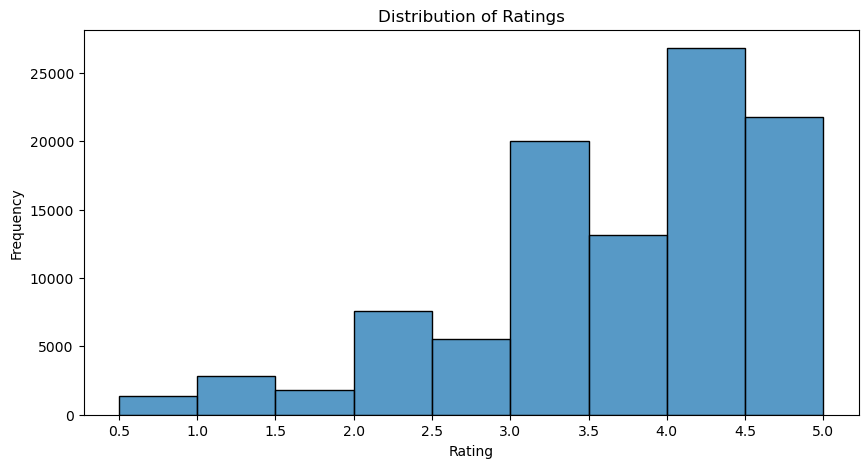

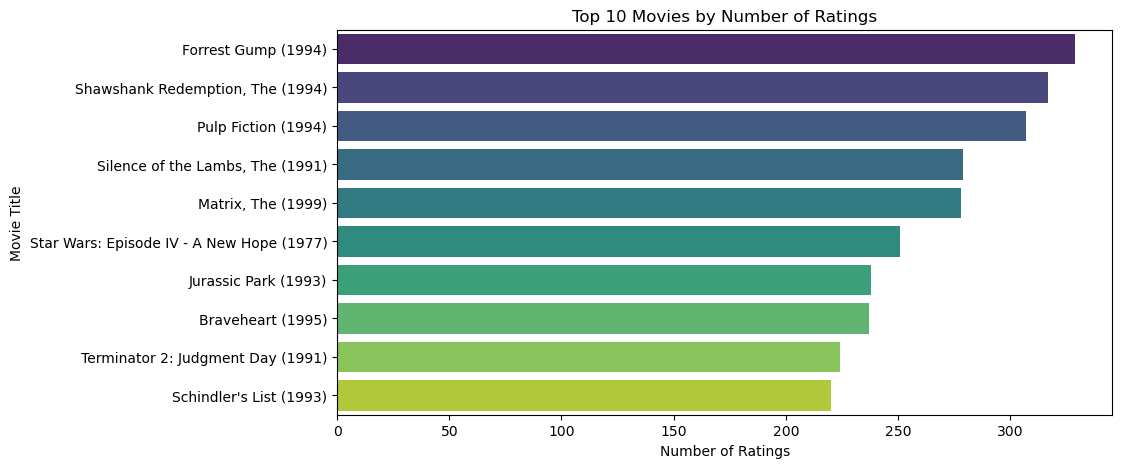

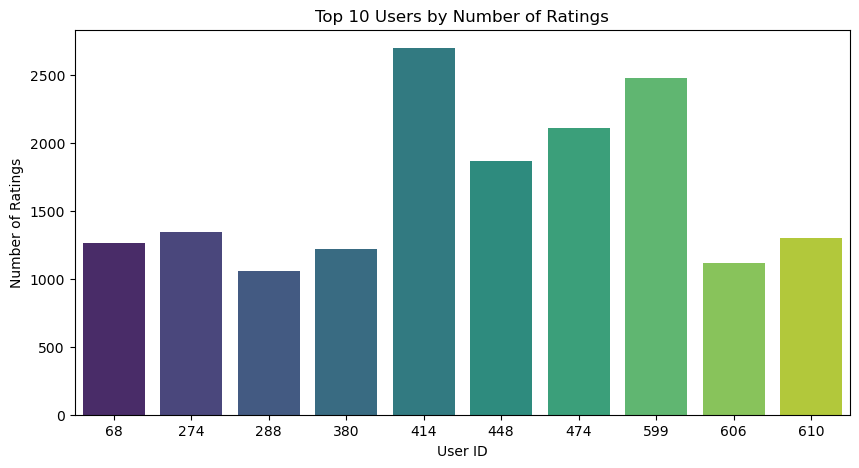

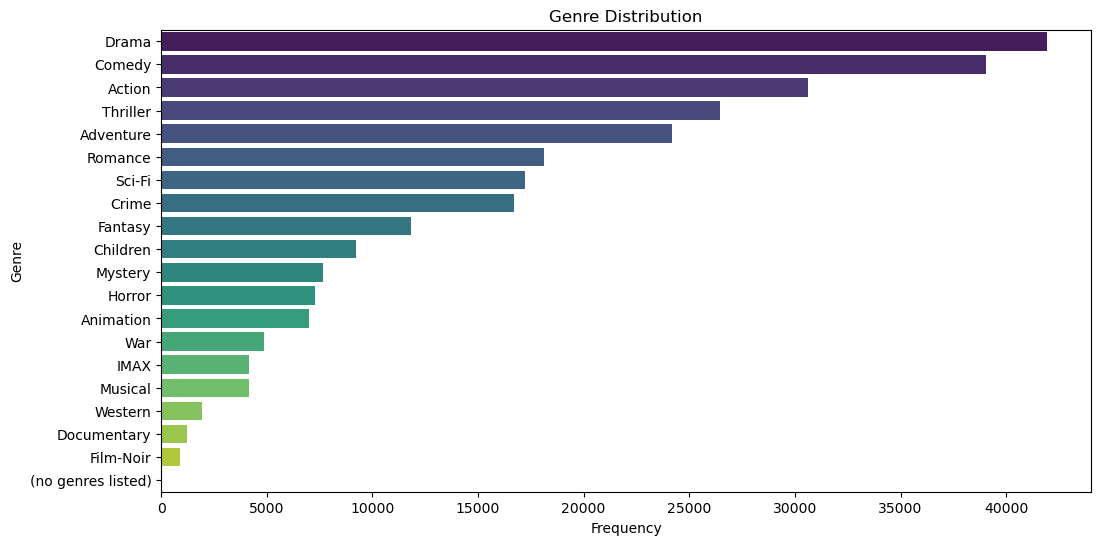

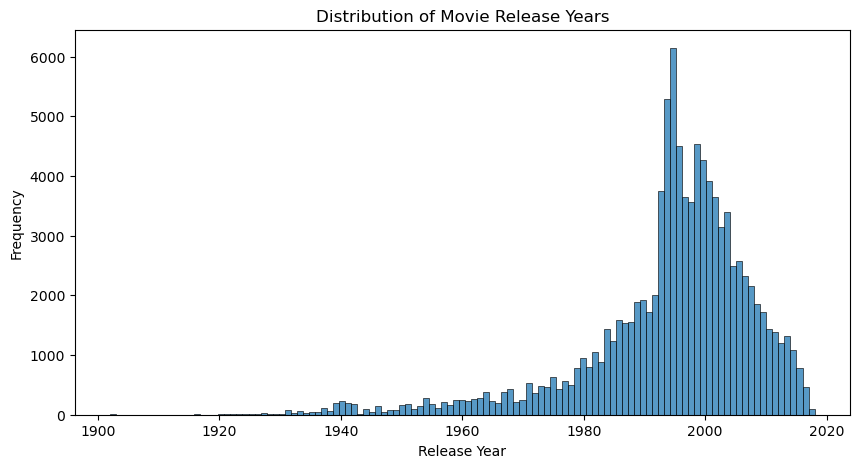

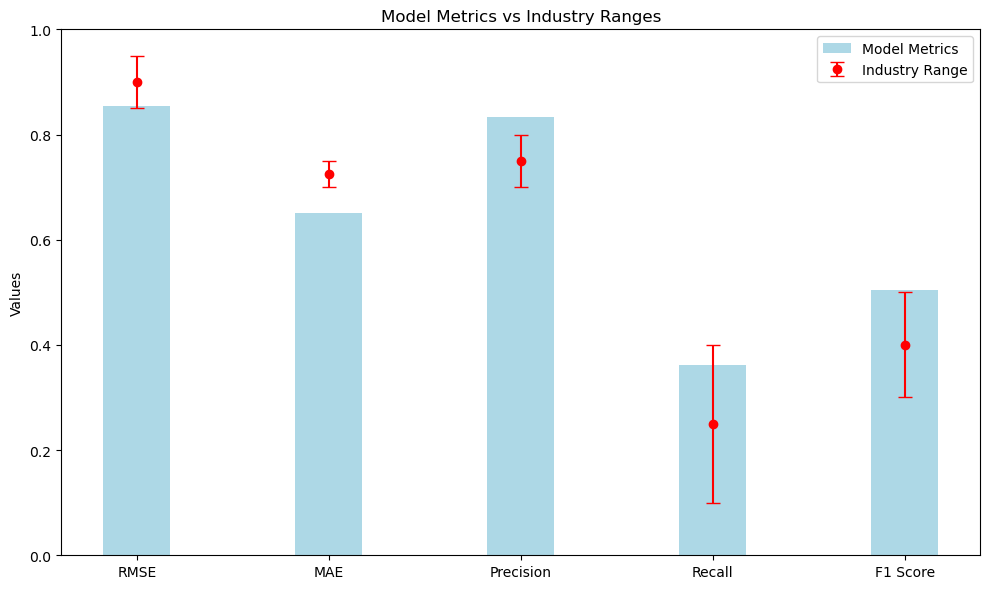

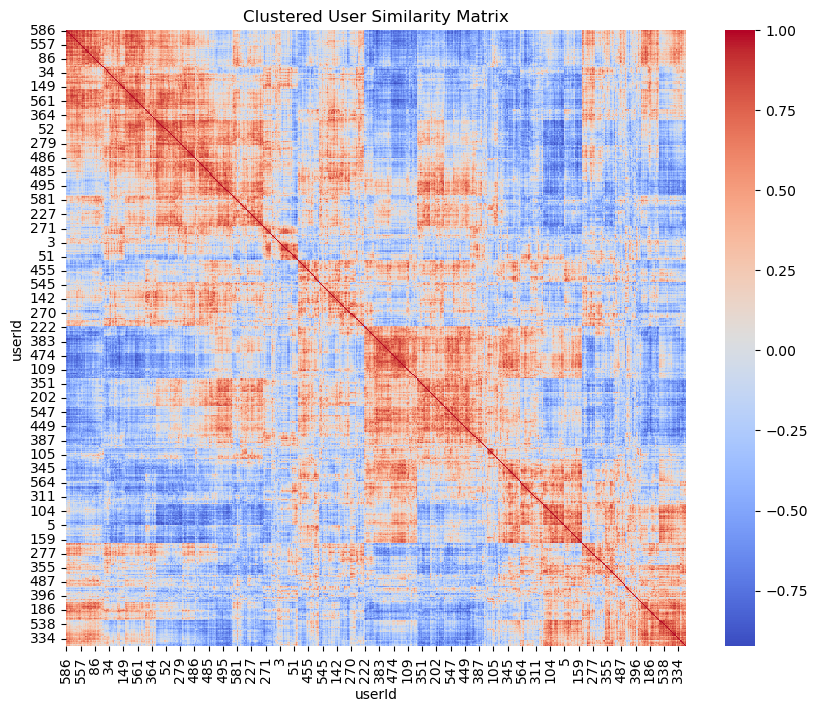

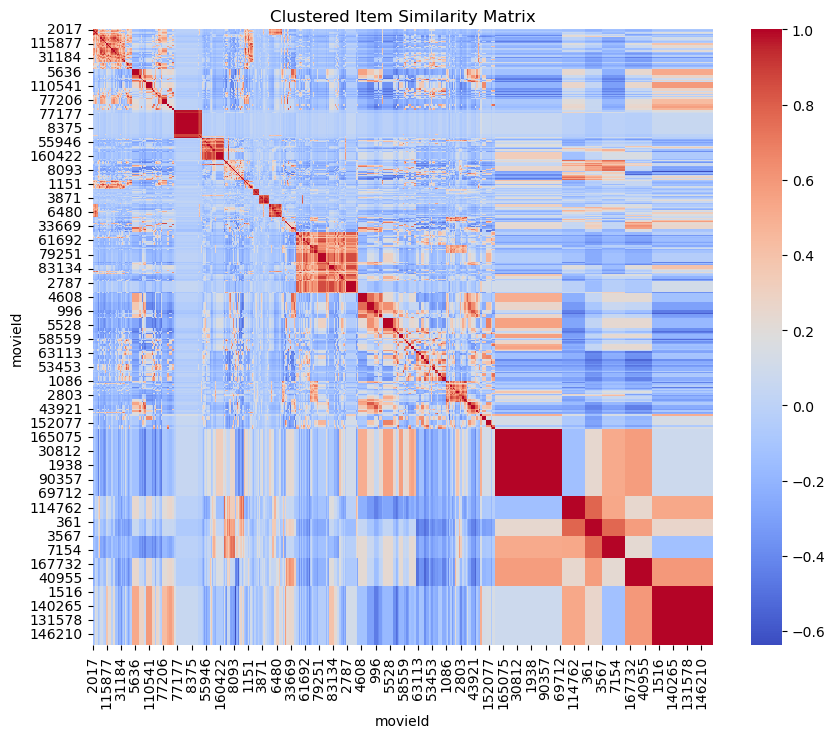

User 1: Generated top 5 recommendations in 15.75 seconds
User 5: Generated top 5 recommendations in 16.53 seconds
User 7: Generated top 5 recommendations in 16.58 seconds
User 15: Generated top 5 recommendations in 16.55 seconds
User 17: Generated top 5 recommendations in 16.79 seconds
User 18: Generated top 5 recommendations in 18.31 seconds
User 19: Generated top 5 recommendations in 14.38 seconds
User 21: Generated top 5 recommendations in 15.58 seconds
User 27: Generated top 5 recommendations in 16.19 seconds
User 31: Generated top 5 recommendations in 15.91 seconds
User 32: Generated top 5 recommendations in 15.88 seconds
User 33: Generated top 5 recommendations in 16.34 seconds
User 40: Generated top 5 recommendations in 16.08 seconds
User 43: Generated top 5 recommendations in 15.78 seconds
User 44: Generated top 5 recommendations in 15.52 seconds
User 45: Generated top 5 recommendations in 15.32 seconds
User 46: Generated top 5 recommendations in 16.33 seconds
User 50: Generate

In [50]:
def main():
    """
    Main function to execute the recommendation system workflow.

    This function orchestrates the loading of data, performing EDA, applying time decay, training the CF model,
    evaluating the model, generating recommendations, and displaying the results.
    """

    # Step 1: Load data
    merged_df, movies_df, ratings_df = load_data(MOVIES_FILE, RATINGS_FILE)

    # Step 2: Perform Exploratory Data Analysis (EDA)
    perform_eda(merged_df)

    # Step 3: Apply time decay to ratings
    merged_df = apply_time_decay(merged_df, TIME_DECAY_FACTOR, YEAR_DIVISOR)

    # Step 4: Initialize Surprise reader and prepare data
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)
    
    # Step 5: Split data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)

    # Step 6: Set up and perform GridSearch to find the best SVD parameters
    param_grid = {'n_factors': [150], 'n_epochs': [100], 'lr_all': [0.01], 'reg_all': [0.1], 'biased': [True]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    # Step 7: Retrieve the best parameters and initialize SVD
    best_params = gs.best_params['rmse']
    algo = SVD(**best_params)

    # Step 8: Evaluate the CF model and compare to industry standards
    model_metrics = evaluate_cf_model(algo, trainset, testset)
    compare_to_industry_standards(model_metrics)

    # Step 9: Define columns for feature standardization
    genre_columns = [col for col in merged_df.columns if col not in ['userId', 'movieId', 'rating', 'title', 'genres', 'release_year', 'timestamp', 'adjusted_rating']]

    # Step 10: Standardize the feature columns
    merged_df = standardize_features(merged_df, genre_columns)

    # Step 11: Extract item features from the dataset
    item_features, non_zero_columns = get_item_features(merged_df, genre_columns)

    # Step 12: Derive user preferences based on standardized features
    user_preferences = derive_user_preferences(merged_df, non_zero_columns)

    # Step 13: Plot the clustered user similarity matrix
    plot_user_similarity_matrix_with_clustering(user_preferences)

    # Step 14: Calculate and plot the clustered item similarity matrix (New Addition)
    item_similarity_df = calculate_item_similarity(item_features)
    plot_item_similarity_matrix_with_clustering(item_similarity_df)
    
    # Step 15: Calculate item popularity based on the ratings data
    item_popularity = calculate_item_popularity(merged_df)

    # Step 16: Calculate Content-Based Filtering (CBF) scores
    cbf_scores, normalized_cbf_scores, user_ids, item_ids = calculate_cbf_scores(merged_df, item_features, user_preferences)

    # Step 17: Calculate Collaborative Filtering (CF) scores
    cf_scores, _, user_ids, item_ids = calculate_scores(algo, merged_df, item_features, user_preferences)

    # Step 18: Generate recommendations for users
    recommendations = {}
    users_with_recommendations = 0
    for user_id in merged_df['userId'].unique()[:USER_SAMPLE_SIZE]:
        if users_with_recommendations >= 20:
            break
        recs = generate_recommendations(algo, merged_df, user_id, N_RECOMMENDATIONS, item_features, user_preferences, item_popularity, cf_scores, normalized_cbf_scores, user_ids, item_ids)
        if not recs:
            continue
        recommendations[user_id] = recs
        users_with_recommendations += 1

    # Step 19: Display metrics to evaluate the recommendation system
    display_metrics(recommendations, len(movies_df), item_popularity, user_preferences, item_features)

if __name__ == "__main__":
    main()  # Run the main function
